## Conformally invariant dissipative relativistic fluid

Here we solve numerically the equations deduced in \ref{xxx}

### To Do:

1. Use KT also (probably has a mistake to check first)
2. Compare with the other code
3. Try some other data
4. Find some interesting (physically) data. The double shock is interesting and could be measured. 

In [1]:
import Pkg; 
#Pkg.activate(mktempdir())
#Pkg.add([
#    Pkg.PackageSpec(name="DifferentialEquations", version="6.16.0"),
#    Pkg.PackageSpec(name="Symbolics", version="0.1.22"),
#    Pkg.PackageSpec(name="ForwardDiff", version="0.10"),
#    Pkg.PackageSpec(name="Plots", version="1"),
#    Pkg.PackageSpec(name="LaTeXStrings", version="1"),
#    Pkg.PackageSpec(name="NonlinearSolve", version="0.3"),
#    Pkg.PackageSpec(name="StaticArrays", version="0.12")
    #Pkg.PackageSpec(name="OrdinaryDiffEq", version="6.17.0"),
#    ])
#Pkg.add("NonlinearSolve")
#Pkg.add("StaticArrays")
#Pkg.add("Symbolics")
#Pkg.add("Symbolics@0.1.22")
#Pkg.add("OrdinaryDiffEq@6.17.0")
#using NonlinearSolve 
using StaticArrays
using Symbolics
using OrdinaryDiffEq
using Plots
using FileIO
using IJuliaBell

In [ ]:
#mkdir("Resultados/Soluciones")

We add the modules needed for the computation:

    choques_utils are the mp5 and kt shock capturing schemes
    
    Flux_functions_ext contain the fluxes and sources for the system
    
    inversion_ext the inversion between conservative and fluid quantities
    
The ext means that we are considering a vector of 10 variables, 5 conservative and 5 fluid variables. The fluid variables are evolved with a zero time derivative, and are updated inside the evolution equation using the inversion function.

In [2]:
include("inversion_ext.jl")

split_u!

In [3]:
include("choques_utils.jl") # all functions needed for evolution
include("Flux_function_ext.jl")

Speed_max (generic function with 1 method)

Some set of parameters:

This have all $v_0(x) = flu_0[i,2] = 0.1 + 0.1 * (x[i] - x0)^4 * (x[i] - x1)^4 / (x1-x0)^8 * 250 $ in the interval $[0.4,0.6]$

$\mu = flu_0[i,1] = -1.$


n_0 χ = [- 1.; 0.; - 1.] Speed = 1 dt/dx = 0.1 T = 2    **This is Euler**

p_1 χ = [- 1.; - 2.; - 10.] Speed = 1 dt/dx = 0.1

p_2 χ = [- 1.; - 2.; - 10.] Speed = 1 dt/dx = 0.01

p_3 χ = [- 1.; - 2.; - 10.] Speed = 10 dt/dx = 0.01

p_4 χ = [- 1.; - 0.5; - 200.] Speed = 1 dt/dx = 0.1

p_5 χ = [- 1.; -0.5; - 5.] Speed = 1 dt/dx = 0.1 (con fuente) T = 2


We now change to a zero background speed and put the pulse near zero so that they don't cross at bad places.

n0_0 χ = [- 1.; 0.; - 1.] Speed = 1 dt/dx = 0.1 T = 2    **This is Euler**

In [32]:
Euler = false
sod = false    # No implementado
speed_pulse = false # a simple speed pulse (no muy interesante pues hay pulsos en las dos direcciones)
temperature_pulse = false # a simple temperature μ pulse (no implementado)
small_pulse_to_the_right = false # low velocity perturbation pulse in just one direction
big_pulse_to_the_right = false # Choques (la velocidad no es muy alta todavía)
big_pulse_negative_I = false
only_diss = false
# poner a continuación la que uno quiere usar con un true (así todos los demás quedan en false)

#big_pulse_to_the_right = true
#big_pulse_to_the_right_E = true
#big_pulse_negative_I = true   #no parece funcionar
small_pulse_to_the_right = true
#only_diss = true

#Euler = true


true

In [33]:
if speed_pulse
    name = "speed_pulse" 
    L=2.4 # Length of the integration region
    M=600 # number of space-points in the discretization
    t=2. # final time
    dx = L/M
    dt = 0.1 * dx # this depends on the maximal propagation speed
    tol = 10^(-10) # error tolerance in inversion function (Newton-Raphson)
    iter_max = 40  # maximum number of NR iterations

    χ = [- 1.0; - 0.1; - 5.0] # the equation parameters 
    ξ = [49.735919716217296; 16.578639905405765; 1] # (λ, κ) dissipative parameters

    
elseif sod
    name = "sod" 
    L=1. # Length of the integration region
    M=400 # number of space-points in the discretization
    t=2. # final time
    dx = L/M
    dt = 0.1 * dx # this depends on the maximal propagation speed
    tol = 10^(-10) # error tolerance in inversion function (Newton-Raphson)
    iter_max = 40  # maximum number of NR iterations

    χ = [- 1.0; - 0.1; - 5.0] # the equation parameters 
    ξ = [49.735919716217296; 16.578639905405765; 1] # (λ, κ) dissipative parameters


elseif  small_pulse_to_the_right
    name = "small_right_p" 
    L=4. # Length of the integration region
    M=600 # number of space-points in the discretization
    t=1. # 4. final time
    dx = L/M
    dt = 0.1 * dx # this depends on the maximal propagation speed
    tol = 10^(-10) # error tolerance in inversion function (Newton-Raphson)
    iter_max = 40  # maximum number of NR iterations

    χ = [- 1.0; - 0.5; - 10.0] # the equation parameters 
    ξ = [49.735919716217296; 16.578639905405765; 1] # (λ, κ) dissipative parameters
    
elseif  big_pulse_to_the_right
    name = "big_right_p" 
    L=4. # Length of the integration region
    M=600 # number of space-points in the discretization
    t=4. # final time
    dx = L/M
    dt = 0.1 * dx # this depends on the maximal propagation speed
    tol = 10^(-10) # error tolerance in inversion function (Newton-Raphson)
    iter_max = 400  # maximum number of NR iterations
    
    χ = [- 1.0; - 0.5; - 10.0] # the equation parameters 
    ξ = [49.735919716217296; 16.578639905405765; 1] # (λ, κ) dissipative parameters
    
elseif  big_pulse_negative_I
    name = "big_right_p_neg_I" 
    L=4. # Length of the integration region
    M=600 # number of space-points in the discretization
    t=0.4 # final time
    dx = L/M
    dt = 0.1 * dx # this depends on the maximal propagation speed
    tol = 10^(-10) # error tolerance in inversion function (Newton-Raphson)
    iter_max = 400  # maximum number of NR iterations
    
    χ = [- 1.0; - 0.5; - 10.0] # the equation parameters 
    ξ = [49.735919716217296; 16.578639905405765; 1] # (λ, κ, a) dissipative parameters
    
elseif  only_diss
    name = "only_diss"
    L=4. # Length of the integration region
    M=600 # number of space-points in the discretization
    t=1. # final time
    dx = L/M
    dt = 0.1 * dx # this depends on the maximal propagation speed
    tol = 10^(-10) # error tolerance in inversion function (Newton-Raphson)
    iter_max = 400  # maximum number of NR iterations
    
    χ = [- 1.0; - 0.0; - 10.0] # the equation parameters 
    ξ = [49.735919716217296; 16.578639905405765; 1] # (λ, κ) dissipative parameters
    
end

if Euler
    χ[2] = 0.
    name = name*"_E"
end

U=10 # number of fields (double the number of fields, one for fluid and the other for conservative quantities)
u_i=zeros(M*U) # flux variables for the initial data (these are used for the flux function)
du=zeros(M*U) # for the rhs
x = zeros(M) # the coordinates
    
par_eq = (χ, ξ) # parameters to use on the equations
par_inv = (χ, tol, iter_max, U, M) # parameters for the inversion
    

([-1.0, -0.5, -10.0], 1.0000000000000006e-10, 40, 10, 600)

In [34]:
#full list of parameters for the evolution function
if χ[2] < 0
    ξ[3] = 1.
    par = (par_eq, par_inv, 1. /dx, U, M, Flux, Speed_max, Is, c_to_f!)
else
    #ξ[3] = -0.1 # with 0 turn off the source
    par = (par_eq, par_inv, 1. /dx, U, M, Flux, Speed_max, Is_dummy, c_to_f!)
    par_cut = (par_eq, par_inv, 1. /dx, U, M, Flux_cut, Speed_max, Is, c_to_f!)
end

 

(([-1.0, -0.5, -10.0], [49.735919716217296, 16.578639905405765, 1.0]), ([-1.0, -0.5, -10.0], 1.0000000000000006e-10, 40, 10, 600), 150.0, 10, 600, Flux, Speed_max, Is, c_to_f!)

In [35]:
# the initial data
# we give initial data in the fluid variables and then transform to conservatives

u_i=zeros(M*U)
con_0 = view(reshape(u_i,(M,U)),:,1:U÷2)
flu_0 = view(reshape(u_i,(M,U)),:,U÷2+1:U)

if speed_pulse
    

    x0 = 0.0; x1 = 0.2 #x0 = 0.4; x1 = 0.6
    v0 = 0.0; δv = 0.1 

    for i in 1:M
        x[i] = dx*(i-1)
        if x[i] > x0 && x[i] < x1
            flu_0[i,2] = v0 + δv *(x[i] - x0)^4 * (x[i] - x1)^4 / (x1-x0)^8 * 250                   #Sz
            flu_0[i,1] = -0.0 # * sin(pi*(x[i] - x0)/(x1-x0))^4 * sin(2*pi*(x[i] - x0)/(x1-x0))     #By
        else
            flu_0[i,2] = v0
        end
    
        flu_0[i,1] = -1.   #
    #flu_0[i,2] = flu_0[i,2] + 0.1  # v
    
    end
f_to_c!(u_i, (χ, U, M)); # populate the conservative variables from the fluid ones
end

if small_pulse_to_the_right

    e0 = 6.; δe = 0.1
    x0 = 0.; x1 = 0.2
    λ = 1. /sqrt(3.)
    for i in 1:M
        x[i] = dx*(i-1)
        if x[i] > x0 && x[i] < x1
            con_0[i,1] = e0 + δe *(x[i] - x0)^4 * (x[i] - x1)^4 / (x1-x0)^8 * 250                   #Sz
            con_0[i,2] = λ*(con_0[i,1] - e0)
        else
            con_0[i,1] = e0
            con_0[i,2] = 0.
        end
            flu_0[i,1] = -1.
    end
    par_inv = (χ, tol, 10000, U, M)
    u_i = c_to_f!(u_i,par_inv);
    reshape(u_i,U,M)
end

if big_pulse_to_the_right || big_pulse_negative_I
    

    e0 = 6.; δe = 4.0
    x0 = 0.; x1 = 0.2
    λ = 1. /sqrt(3.)
    for i in 1:M
        x[i] = dx*(i-1)
        if x[i] > x0 && x[i] < x1
            con_0[i,1] = e0 + δe *(x[i] - x0)^4 * (x[i] - x1)^4 / (x1-x0)^8 * 250                   #Sz
            con_0[i,2] = λ*(con_0[i,1] - e0)
        else
            con_0[i,1] = e0
            con_0[i,2] = 0.
        end
            flu_0[i,1] = -sqrt(con_0[i,1])/6
    end
    
    if !Euler
        χ_int = [- 1.0; -0.; - 10.0] #primero nos aproximamos a la solución con χ₁=0
        par_inv = (χ, tol, 1000, U, M)
        u_i = c_to_f!(u_i,par_inv);
        χ = [- 1.0; -0.5; - 10.0] #luego buscamos la buena con la semilla anterior
        par_inv = (χ, tol, 1000, U, M)
        u_i = c_to_f!(u_i,par_inv);
        #check!
        if max(abs, f_to_c!(u_i,(χ,U,M)) - u_i) > 0.001
            error("Not converging")
        end
    else
        u_i = c_to_f!(u_i,par_inv);
    end
        reshape(u_i,U,M)
end

if only_diss

    e0 = 6.; δe = 0.0
    x0 = 0.; x1 = 0.2
    x10 = 0.1
    x20 = 0.1
    x30 = 0.1
    #λ = 1. /sqrt(3.)
    for i in 1:M
        x[i] = dx*(i-1)
        if x[i] > x0 && x[i] < x1
            con_0[i,1] = e0
            con_0[i,3] = x10 *(x[i] - x0)^4 * (x[i] - x1)^4 / (x1-x0)^8 * 250                   #Sz
            con_0[i,4] = x20 *(x[i] - x0)^4 * (x[i] - x1)^4 / (x1-x0)^8 * 250 
            con_0[i,5] = x30 *(x[i] - x0)^4 * (x[i] - x1)^4 / (x1-x0)^8 * 250 
        else
            con_0[i,1] = e0
        end
        flu_0[i,1] = -1.
    end
        u_i = c_to_f!(u_i,par_inv);
        reshape(u_i,U,M);
end

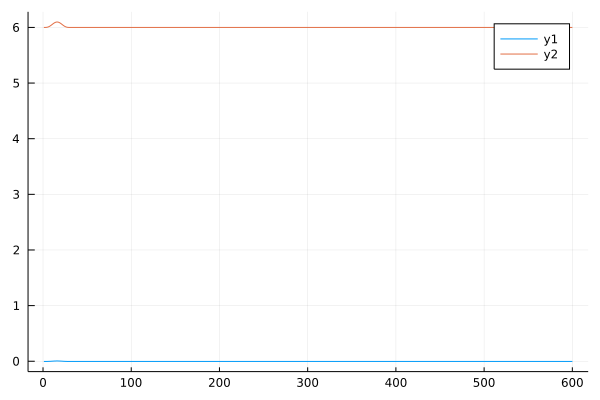

In [36]:
plot(flu_0[:,1] .+ 1) #plot(flu_0[:,1] .- 6)
plot!(con_0[:,1])

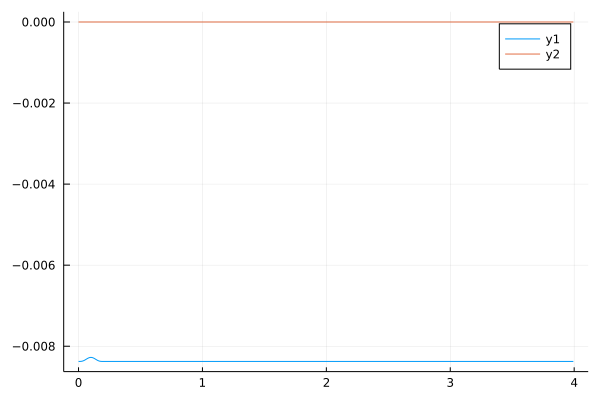

In [37]:
plot(x,flu_0[:,5])
plot!(x,con_0[:,5])

In [38]:
function evolution(du,u,par,t)
    # this is the function that is taken by the time-integrator
    par_eq, par_inv, h_1, U, M, Flux, Speed_max, Source, c_to_f = par
    χ, ζ = par_eq
    
    #p_direct = (χ, U, M) #these are the parameters for direct
    #c_to_f_direct!(u,p_direct)
    c_to_f!(u,par_inv)
    
    par_mp5 = (h_1, U, M, χ, par_eq, Flux, Speed_max, Source)
    for j ∈ 1:M
        mp5(du,u,par_mp5,j,t)
    end
    return du[:]
end

evolution (generic function with 1 method)

Me make a smaller `dt` evolution for a while in case that the field has to adjust to the sources in a very fast exponential way.

In [ ]:
if !Euler
    u_r = zeros(U*M) # Initialization for the second, longer dt step.
    prob_i = ODEProblem(evolution,u_i,(0.0,0.1*t),par); # solves without changing e and s

    
    #sol = solve(prob_euler_direct,SSPRK33(),dt=dt,saveat=0.01*t); # This, I think, is a TVD method
    sol_i = solve(prob_i,SSPRK33(),dt=0.1*dt,saveat=0.01*t); 
    u_r = sol_i(0.1*t)

    field = 1
    #plot(x,reshape(sol(0.),(M,U))[:,field])
    #plot!(x,reshape(sol(t/8),(M,U))[:,field])
    #plot!(x,reshape(sol(t/4),(M,U))[:,field])
    #plot!(x,reshape(sol(t/2),(M,U))[:,field])
    plot(x,reshape(sol_i(t/1),(M,U))[:,field])
    
else
    prob = ODEProblem(evolution,u_i,(0.0,t),par);
end

In [ ]:
prob = ODEProblem(evolution,u_i,(0.0,t),par);
sol = solve(prob,SSPRK33(),dt=dt,saveat=0.01*t);
    #sol = solve(prob,SSPRK33(),saveat=0.01*t);
#sol = solve(prob,SSPRK33(),dt=dt,save_everystep=false) # to get just the end values
#sol = solve(prob,RK4(),dt=dt);
@bell sleep(3)

In [ ]:
sol_i;

In [ ]:
field = 4
plot(x,reshape(sol_i(0.1*t),(M,U))[:,field])
u_r = sol_i(0.1*t)
plot!(x,reshape(u_r,(M,U))[:,field])

In [ ]:
if !Euler
    prob = ODEProblem(evolution,u_r,(0.1*t,0.5*t),par);
    sol = solve(prob,SSPRK33(),dt=dt,saveat=0.01*t);
end
@bell sleep(3)

In [ ]:
save("Resultados/Soluciones/$name.jld2", Dict("$name" => sol))
#sol = load("Resultados/Soluciones/$name.jld2","$name");

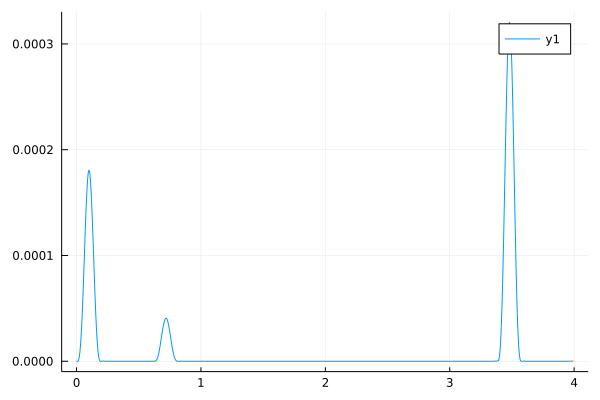

In [25]:
#sol(t) = sol_nr_p5(t) - sol_nr_n0(t)
#sol(t) = sol_n0_0(t)
field = 10
#plot(x,reshape(sol(0.),(M,U))[:,field])
#plot!(x,reshape(sol(t/8),(M,U))[:,field])
#plot!(x,reshape(sol(t/4),(M,U))[:,field])
#plot!(x,reshape(sol(t/2),(M,U))[:,field])
plot(x,reshape(sol(0.2*t),(M,U))[:,field])

┌ Info: Saved animation to 
│   fn = /Users/reula/Julia/Fluidos_Conformes/Resultados/Movies/only_diss.gif
└ @ Plots /Users/reula/.julia/packages/Plots/kyYZF/src/animation.jl:104


Plots.AnimatedGif("/Users/reula/Julia/Fluidos_Conformes/Resultados/Movies/only_diss.gif")
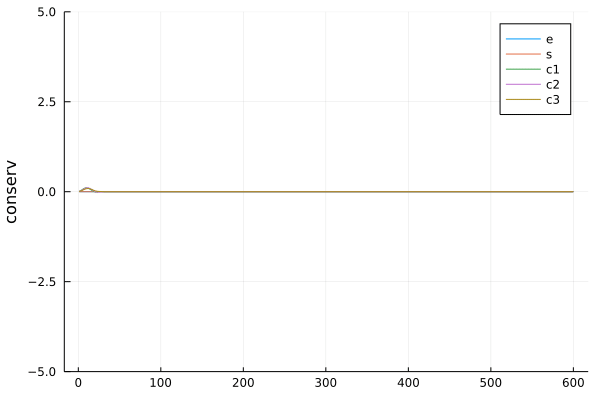

In [26]:
##### ssol(t) = sol_dir_n0(t)
#ssol(t) = sol(t)
t=4
shift = 0# U÷2 # 0 is conserv otherwise is fluid
anim = @animate for i ∈ 1:100
    plot(reshape(sol(t*0.01*i),(M,U))[:,shift+1] .- 6.0,label="e", yaxis = ("conserv", (-5,5)))
    plot!(reshape(sol(t*0.01*i),(M,U))[:,shift+2] .- 0.,label="s")
    plot!(reshape(sol(t*0.01*i),(M,U))[:,shift+3],label="c1")
    plot!(reshape(sol(t*0.01*i),(M,U))[:,shift+4],label="c2")
    plot!(reshape(sol(t*0.01*i),(M,U))[:,shift+5],label="c3")
end

gif(anim, "Resultados/Movies/con_$name.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/reula/Julia/Fluidos_Conformes/Resultados/Movies/flu_only_diss.gif
└ @ Plots /Users/reula/.julia/packages/Plots/kyYZF/src/animation.jl:104


Plots.AnimatedGif("/Users/reula/Julia/Fluidos_Conformes/Resultados/Movies/flu_only_diss.gif")
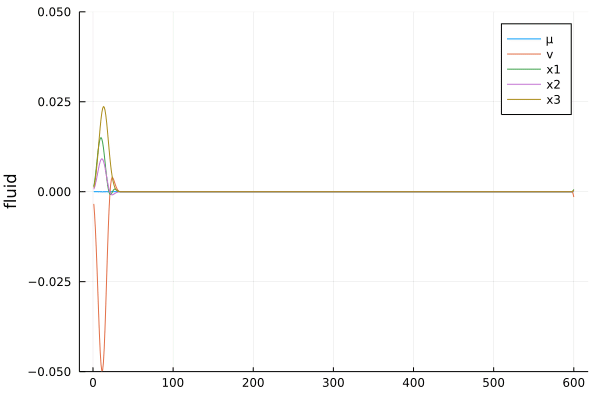

In [31]:
#ssol(t) = sol_dir_n0(t)
ssol(t) = sol(t)
shift = U÷2 # 0 is conserv otherwise is fluid
anim = @animate for i ∈ 1:100
    plot(reshape(ssol(t*0.01*i),(M,U))[:,shift+1] .+ 1,label="μ", yaxis = ("fluid", (-0.05,0.05)))
    plot!(200 .* (reshape(ssol(t*0.01*i),(M,U))[:,shift+2]) ,label="v")
    plot!(reshape(ssol(t*0.01*i),(M,U))[:,shift+3].*50 ,label="x1")
    plot!(reshape(ssol(t*0.01*i),(M,U))[:,shift+4].*50 ,label="x2")
    plot!(reshape(ssol(t*0.01*i),(M,U))[:,shift+5].*50 ,label="x3")
end

gif(anim, "Resultados/Movies/flu_$name.gif", fps = 10)

In [ ]:
##### ssol(t) = sol_dir_n0(t)
ssol(t) = sol(t)
t = 2
shift = 0# U÷2 # 0 is conserv otherwise is fluid
    plot(reshape(ssol(t),(M,U))[:,shift+1] .- 6.0,label="e", xlim = (160,280), yaxis = ("conserv", (-5,5)))
    plot!(reshape(ssol(t),(M,U))[:,shift+2] .- 0.,label="s")
    plot!(reshape(ssol(t),(M,U))[:,shift+3],label="c1")
    plot!(reshape(ssol(t),(M,U))[:,shift+4],label="c2")
    plot!(reshape(ssol(t),(M,U))[:,shift+5],label="c3")

#### Aquí siguen celdas que solo importan para pruebas.

## Euler equations

We recuperate Euler's equations setting $\chi_1 = 0$ and the dissipative variables to zero. That way the systems decouple. And we get: (the notation here is a bit misleading,
here $\rho \approx e$ Different from $E = (\rho + p) = 4/3 \rho$, since $p = \frac{1}{3}\rho$ and so $s = Ev = 4/3 e v$

$F_e = \frac{4}{3}ργ^2v = s$

$F_s = \frac{4}{3}ρ(γ^2v^2 + \frac{1}{4}) = \frac{1}{3}ργ^2(4 v^2 + \frac{1}{\gamma^2} = 
\frac{1}{3}ργ^2(3v^2 + 1) $

$e = \frac{4}{3}ρ(γ^2 - \frac{1}{4}) = \frac{1}{3}ργ^2(4 - \frac{1}{\gamma^2}) = \frac{1}{3}ργ^2(3 + v^2)$

$s = \frac{4}{3}ργ^2v$

$4\frac{e}{s}v - (3 + v^2) = 0$

$v = 2\frac{e}{s} \pm \sqrt{4(\frac{e}{s})^2 -3}$

$v_- =  \frac{3}{2\frac{e}{s} + \sqrt{4(\frac{e}{s})^2 -3}} \approx \frac{3s}{4e}$


In [ ]:
function evolution_euler_direct(du,u,par,t) # here χ₁=0!
    # this is the function that is taken by the time-integrator
    par_eq, par_inv, h_1, U, M, Flux, Speed_max, Source, c_to_f = par
    χ = par_eq
    
    p_direct = (χ, U, M) #these are the parameters for direct
    c_to_f_direct!(u,p_direct)
    #c_to_f!(u,par_inv)
    
    par_mp5 = (h_1, U, M, χ, χ, Flux, Speed_max, Source)
    for j ∈ 1:M
        mp5(du,u,par_mp5,j)
    end
    return du[:]
end

In [ ]:

prob_euler_direct = ODEProblem(evolution_euler_direct,u_i,(0.0,t),par);

In [ ]:
#sol = sol_dir_n0;
dsol(t) = sol_nr_n0(t) - sol_dir_n0(t);
reshape(dsol(0.),(M,U))[:,1];

In [ ]:
field = 1
plot(reshape(sol_nr_n0(0.),(M,U))[:,field] .- reshape(sol_dir_n0(0.),(M,U))[:,field])
plot!(reshape(sol_nr_n0(t/8),(M,U))[:,field] .- reshape(sol_dir_n0(t/8),(M,U))[:,field])
plot!(reshape(sol_nr_n0(t/4),(M,U))[:,field] .- reshape(sol_dir_n0(t/4),(M,U))[:,field])
plot!(reshape(sol_nr_n0(t/2.1),(M,U))[:,field] .- reshape(sol_dir_n0(t/2.1),(M,U))[:,field])
#plot!(reshape(sol_nr_n0(t/1.1),(M,U))[:,field] .- reshape(sol_dir_n0(t/1.1),(M,U))[:,field])

In [ ]:
anim = @animate for i ∈ 1:100
    plot(reshape(dsol(t*0.01*i),(M,U))[:,1],label="e", yaxis = ("conserv", (-1e-7,1e-7)))
    plot!(reshape(dsol(t*0.01*i),(M,U))[:,2],label="s")
    plot!(reshape(dsol(t*0.01*i),(M,U))[:,3],label="c1")
    plot!(reshape(dsol(t*0.01*i),(M,U))[:,4],label="c2")
    plot!(reshape(dsol(t*0.01*i),(M,U))[:,5],label="c3")
end

gif(anim, "ff_n0_dif_anim_fps10.gif", fps = 10)

In [ ]:
anim = @animate for i ∈ 1:100
    plot(reshape(dsol(t*0.01*i),(M,U))[:,5+1],label="μ", yaxis = ("fluid", (-1e-8,1e-8)))
    plot!(reshape(dsol(t*0.01*i),(M,U))[:,5+2],label="v")
    plot!(reshape(dsol(t*0.01*i),(M,U))[:,5+3],label="X1")
    plot!(reshape(dsol(t*0.01*i),(M,U))[:,5+4],label="X2")
    plot!(reshape(dsol(t*0.01*i),(M,U))[:,5+5],label="X3")
end

gif(anim, "ff_n0_dif_anim_fps10.gif", fps = 10)